# Paper Section: Fig 1 in Results

Following these analysis, we observe that a good fit requires at least a few data points at the linear range. Thus, the worklfow for generating learning curves can be as follows. That is particularly efficient sequential processing.
1. Start with the largest training subset, and proceed to smaller subsets with a pre-defined step size.
2. Generate at least 4 learning curve points and fit power-law. Record RMSE (goodness-of-fit).
3. Starting from the 5th point (that's a heuristic), fit a power-law to the existing learning curve points. If the fit does not improve, as measured by RMSE, we terminate the workflow.

Notes:<br>
We evaluate the quality (usefulness) of fit with two measures:
1. RMSE
2. Ability to extrapolate

Question:
1. Why plots generated by LGBM and RF are so consistent across runs?? Is it because we use the same random_state??

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/LearningCurves/notebooks


### Get dir path of all runs

In [21]:
src = 'gdsc'
# src = 'ctrp'

In [126]:
# Runs dir
# CCLE - very small difference when usgin default and LS-best HPs to generate LC
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_no-HPO')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_LS-Best')

# GDSC
if src=='gdsc':
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_1000_trees_no_hpo')
    
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees')

# CTRP - the fit default hps is not good; 
elif src=='ctrp':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_1000_trees_no_hpo') # not ready
    
# Get all run dirs
runs = glob(str(base_dir/'*'))

### Aggregate results over runs

In [127]:
scores = []
for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])

In [128]:
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)

display(scores[:2])

,metric,tr_size,set,std,median,mean,run1,run2,run3,run4,...,run11,run12,run13,run14,run15,run16,run17,run18,run19,run20
0,mean_absolute_error,2,tr,0.048166,0.0753,0.090463,0.0484,0.007750,0.116750,0.069200,...,0.074300,0.069400,0.1117,0.130400,0.081500,0.2061,0.11190,0.062450,0.183250,0.021650
1,mean_absolute_error,4,tr,0.038316,0.1073,0.114236,0.0676,0.121675,0.098875,0.092862,...,0.162375,0.187937,0.0969,0.132925,0.093325,0.1355,0.17375,0.083025,0.115725,0.165288


In [129]:
save = False
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

### Fig (a) Learning curves plotted on linear scale, generated using GBDT for multiple data shuffles of GDSC [/CTRP].

In [130]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

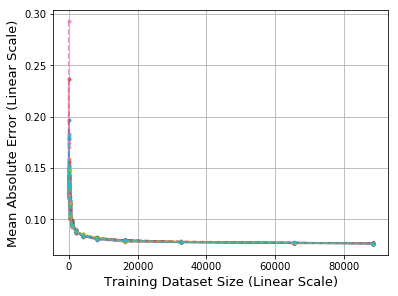

In [131]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );

### Fig (b) Learning curves plotted on log-log scale, generated using GBDT for multiple data shuffles of GDSC [/CTRP].

- When data is presented on log-log scale, it is easier to discriminate between the different regions of model improvement.

Other comments:<br>
- Certain shuffles generate data that does not result in a successful power law fit when all points are used.
- As a result, we generate data for multiple seeds and aggregate across runs via median.
- Then, we fit a power law to the aggregated LC data.

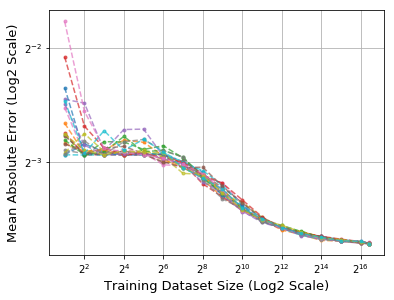

In [132]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );

### Fig (c) Median and standard deviation per subset size across all runs.

- STD of scores across runs is inversely proportional to the subset size. This can be attributed to the distribution similarity of target values between training subset and test set. The target values, is our use case, are the dose-independent values. The smaller the subset, the lower the similarity with a test set, and therefore, we observe larger variance of scores across runs [shuffles/experiments] at smaller subsets.
- We exploit this observation for ... [Mukherjee exploits this observation ...]

In [133]:
figsize = (6, 4.5)
# figsize = (10, 8)
metric_name = 'mean_absolute_error'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

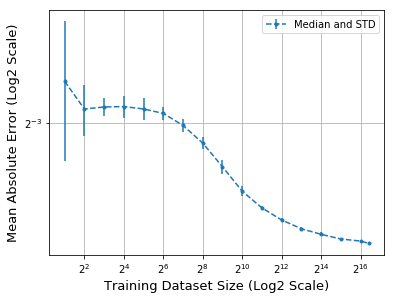

In [134]:
scores_te = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

shard_min_idx=0
# shard_min_idx=1

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:], yerr=scores_te['std'][shard_min_idx:],
        ax=ax, ls='--', marker='.', alpha=1,
        **plot_args, label='Median and STD')

ax.legend(frameon=True, fontsize=10, loc='best');

### Fig (d) Power-law fit to all data points.

RMSE: 0.00567393525639315


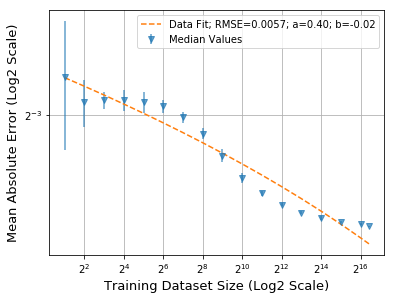

In [135]:
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te['median'][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0
ax, _, rmse = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1);

ax.legend(frameon=True, fontsize=10, loc='best')

print('RMSE:', rmse)

### Fig (e) Power-law fit to a subset of points.
- The fit improves (smaller RMSE) by exclusing some of the initial points.
- We also observe that better fits result in better agreement with the theoretical values of the power-fit. Specifically, the value of beta.

RMSE: 0.0001394558315074812


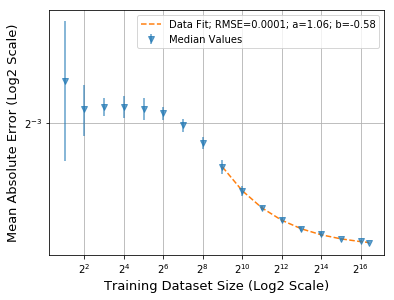

In [148]:
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te['median'][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

# shard_min_idx = 1
# shard_min_idx = 2
# shard_min_idx = 3
# shard_min_idx = 4
# shard_min_idx = 5
# shard_min_idx = 6
# shard_min_idx = 7
shard_min_idx = 8
ax, _, rmse = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

ax.legend(frameon=True, fontsize=10, loc='best')

print('RMSE:', rmse)

### Fig (f) RMSE as a function of starting point

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

In [149]:
# tot_points - min_points

tot_points 17


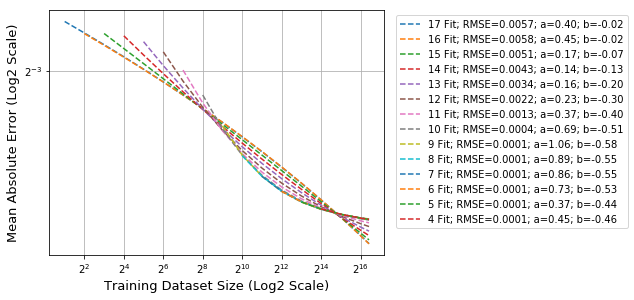

In [151]:
tot_points = len(scores_te['tr_size'])
print('tot_points', tot_points)
# min_points = 3 # 3 points doesn't work
min_points = 4

p_arr = []
rmse_arr = []
prm_arr = []
ax = None
for shard_min_idx in range(tot_points - min_points + 1):
    n_points = tot_points - shard_min_idx
    
    ax, prm, rmse = lrn_crv_plot.plot_lrn_crv_power_law(
            x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
            **plot_args, ax=ax, plot_raw=False, label=str(n_points) );
    
    prm_arr.append(prm)
    rmse_arr.append(rmse)
    # p_arr.append(tot_points - shard_min_idx)
    p_arr.append(n_points)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

In [152]:
idx = np.array(rmse_arr).argmin()
p_arr[idx]

8

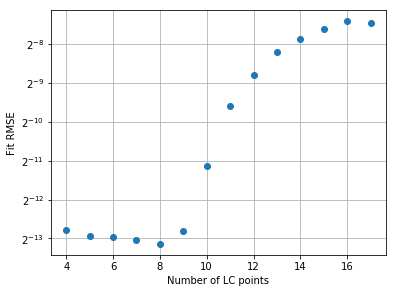

In [166]:
# print(p_arr)
# print(rmse_arr)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(p_arr, rmse_arr, 'o');
plt.xlabel('Number of LC points')
plt.ylabel('Fit RMSE')
plt.grid(True)
ax.set_yscale('log', basey=2)
# ax.set_xscale('log', basex=2)

# Extrapolate

In [155]:
# tot_points = len(scores_te['tr_size'])
# print('tot_points', tot_points)
# # min_points = 3 # 3 points doesn't work
# min_points = 4

# p_arr = []
# rmse_arr = []
# prm_arr = []
# ax = None
# for shard_min_idx in range(tot_points - min_points + 1):
#     n_points = tot_points - shard_min_idx
#     ax, prm, rmse = lrn_crv_plot.plot_lrn_crv_power_law(
#             x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
#             **plot_args, ax=ax, plot_raw=False, label=str(n_points) );
#     prm_arr.append(prm)
#     rmse_arr.append(rmse)
#     # p_arr.append(tot_points - shard_min_idx)
#     p_arr.append(n_points)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

RMSE: 0.0001428639093364567


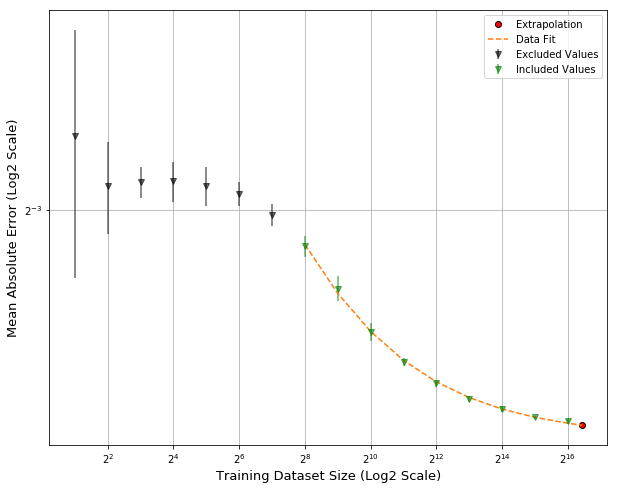

In [176]:
p_et = 1
m0 = len(scores_te['tr_size']) - p_et
plot_args['figsize'] = (10, 8)

# shard_min_idx = 1
# shard_min_idx = 2
# shard_min_idx = 3
# shard_min_idx = 4
# shard_min_idx = 5
# shard_min_idx = 6
shard_min_idx = 7
# shard_min_idx = 8

ax = None
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x=scores_te['tr_size'][0:m0], y=scores_te['median'][0:m0], yerr=scores_te['std'][0:m0],
#         ax=ax, ls='', marker='v', alpha=0.7,
#         **plot_args, label='Excluded Values')

ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:shard_min_idx], y=scores_te['median'][0:shard_min_idx], yerr=scores_te['std'][0:shard_min_idx],
        ax=ax, ls='', marker='v', alpha=0.6, color='k',
        **plot_args, label='Excluded Values')

ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][shard_min_idx:m0], y=scores_te['median'][shard_min_idx:m0], yerr=scores_te['std'][shard_min_idx:m0],
        ax=ax, ls='', marker='v', alpha=0.6, color='g',
        **plot_args, label='Included Values')

ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
        p_et=p_et,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax.legend(frameon=True, fontsize=10, loc='best')
# ax.set_xlim(min(scores_te['tr_size']), max(scores_te['tr_size'])+10000)

print('RMSE:', rmse)